In [16]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models,layers,datasets,regularizers

In [17]:
# Sélectionner l'ensemble de données mnist
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Modifier la dimension des images
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Modèle CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(10, activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# Modèle de train
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 41s 21ms/step - loss: 0.2026 - accuracy: 0.9539 - val_loss: 0.0892 - val_accuracy: 0.9834
Epoch 2/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0837 - accuracy: 0.9837 - val_loss: 0.0671 - val_accuracy: 0.9874
Epoch 3/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0650 - accuracy: 0.9873 - val_loss: 0.0601 - val_accuracy: 0.9870
Epoch 4/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0553 - accuracy: 0.9891 - val_loss: 0.0509 - val_accuracy: 0.9891
Epoch 5/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0479 - accuracy: 0.9911 - val_loss: 0.0484 - val_accuracy: 0.9912
Epoch 6/10
1875/1875 [==============================] - 37s 19ms/step - loss: 0.0428 - accuracy: 0.9923 - val_loss: 0.0455 - val_accuracy: 0.9913
Epoch 7/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0395 - accuracy: 0.9929 - val_loss: 0.0542 -

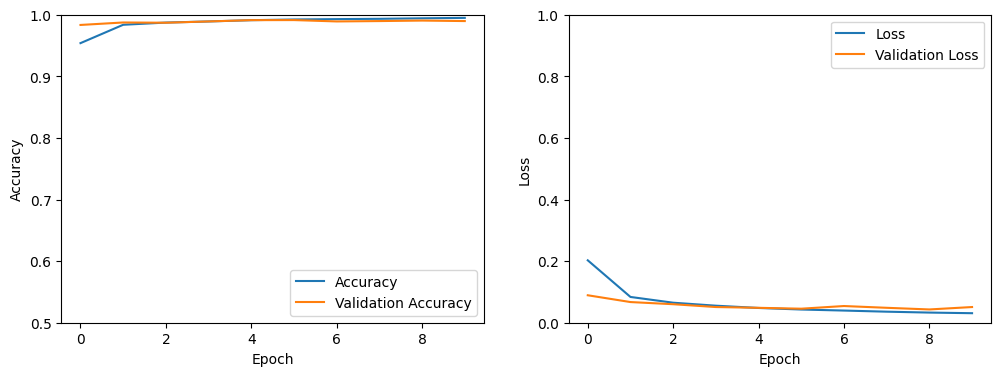

In [19]:
# Tracer les courbes de précision et de perte pendant la formation.
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')

plt.show()

In [20]:
# Modèle d'évaluation sur le dataset test
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 2s - loss: 0.0509 - accuracy: 0.9897 - 2s/epoch - 7ms/step

Test accuracy: 0.9897000193595886


## Prêt à générer des échantillons adversarials

In [25]:
# Fonction permettant de générer des échantillons contradictoires
def generate_adversarial_samples(input_image, input_label, model, epsilon):
    input_image = tf.convert_to_tensor(input_image, dtype=tf.float64)
    input_label = tf.convert_to_tensor(input_label, dtype=tf.uint8)
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

    # Utiliser tf.GradientTape pour obtenir les gradients
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = model(input_image, training=False)
        loss = loss_object(input_label, predictions)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)  
    perturbations = epsilon*signed_grad
    return perturbations

In [26]:
# Utiliser dataset train pour generer les perturbations
eps = 0.25
perturbations = generate_adversarial_samples(x_train, y_train, model, eps) 
x_train_adv = x_train + perturbations
x_train_adv = tf.clip_by_value(x_train_adv, 0, 1) # Clip sur x_train_adv

# Prédire l'ensemble des données train
y_train_pred_original = model.predict(x_train)
# Convertir les prédictions en étiquettes de catégorie
predicted_labels_original = np.argmax(y_train_pred_original, axis=1)

# Prédire l'ensemble des données adversaires
y_adv_pred_adv = model.predict(x_train_adv)
# Convertir les prédictions en étiquettes de catégorie
predicted_labels_adv = np.argmax(y_adv_pred_adv, axis=1)


def get_confidence(predictions):
    confidences = tf.math.reduce_max(predictions, axis=-1)
    # Conversion des niveaux de confiance en pourcentages
    return confidences.numpy() * 100

confidences_original = get_confidence(y_train_pred_original)
confidences_adv = get_confidence(y_adv_pred_adv)

1875/1875 [==============================] - 12s 7ms/step


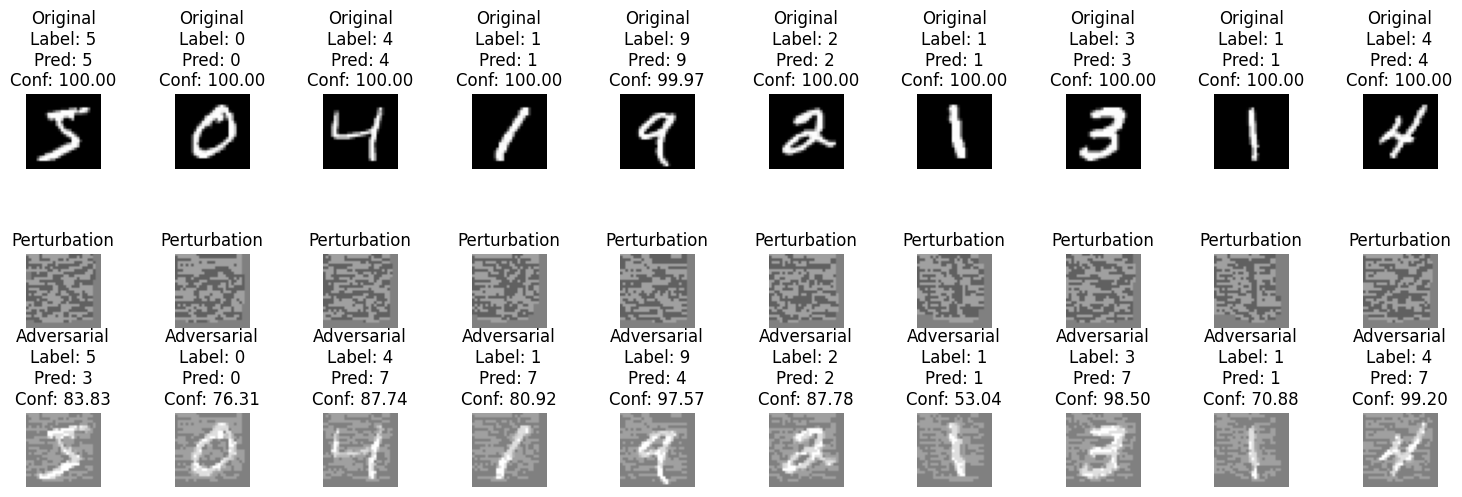

In [27]:
# images des perturbations
num_images = 10  
plt.figure(figsize=(15, 5))
for i in range(num_images):
    actual_label = y_train[i]

    # Première ligne : image originale avec ses étiquettes et ses niveaux de confiance
    plt.subplot(3, num_images, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Original\nLabel: {actual_label}\nPred: {predicted_labels_original[i]}\nConf: {confidences_original[i]:.2f}")
    plt.axis('off')

    # Ligne 2 : Perturbation
    plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(tf.squeeze(perturbations[i]), cmap='gray', vmin=-1, vmax=1)
    plt.title("Perturbation")
    plt.axis('off')
    
    # Ligne 3 : Échantillons adverses, leurs étiquettes et leurs niveaux de confiance
    plt.subplot(3, num_images, i + 1 + 2*num_images)
    plt.imshow(tf.squeeze(x_train_adv[i]), cmap='gray', vmin=-1, vmax=1)
    plt.title(f"Adversarial\nLabel: {actual_label}\nPred: {predicted_labels_adv[i]}\nConf: {confidences_adv[i]:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
# Modèle d'évaluation sur le dataset test
test_loss, test_acc = model.evaluate(x_train_adv,  y_train, verbose=2)
print('\nAdversarial smaples Test accuracy:', test_acc)

1875/1875 - 13s - loss: 2.5449 - accuracy: 0.3213 - 13s/epoch - 7ms/step

Adversarial smaples Test accuracy: 0.3212999999523163


## Début de la formation à la défense contre les échantillons contradictoires

In [29]:
model_adv = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_adv.compile(optimizer='adam',
              loss=None,
              metrics=['accuracy'])

In [30]:
# Créez un jeu de données train_dataset train_dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

batch_size = 64
train_dataset = train_dataset.batch(batch_size)

alpha = 0.5
epochs = 5
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Définir des indicateurs pour mesurer le loss
loss_metric = tf.keras.metrics.Mean()

# Définir des indicateurs pour mesurer la précision
accuracy_metric_original = tf.keras.metrics.SparseCategoricalAccuracy()
accuracy_metric_adv = tf.keras.metrics.SparseCategoricalAccuracy()

# Cycle de training
for epoch in range(epochs):
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            
            eps = 0.25
            x_adv = generate_adversarial_samples(x_batch, y_batch, model_adv, eps) 
            x_adv = tf.clip_by_value(x_adv, 0, 1) 
            
            # Prédire l'ensemble des données train
            y_train_pred_original = model_adv(x_batch, training=True)  # Propagation vers l'avant

            # Prédire l'ensemble des données adversaires
            y_train_pred_adv = model_adv(x_adv, training=True)  # Propagation vers l'avant
            
            loss_origin = loss_function(y_batch, y_train_pred_original)  # Loss de x_train
            loss_adv = loss_function(y_batch, y_train_pred_adv)  # Loss de x_train_adv
            loss_total = alpha*loss_origin + (1-alpha)*loss_adv
                    
        # (Backpropagation)Calculer le gradient de la fonction de perte par rapport aux paramètres du modèle.
        gradients = tape.gradient(loss_total, model_adv.trainable_variables)

        # 
        optimizer.apply_gradients(zip(gradients, model_adv.trainable_variables))
                
        # Renouveler les mesures de précision et de loss_total
        accuracy_metric_original.update_state(y_batch, y_train_pred_original)
        accuracy_metric_adv.update_state(y_batch, y_train_pred_adv)
        loss_metric.update_state(loss_total)
    
    mean_loss = loss_metric.result()
    mean_accuracy_original = accuracy_metric_original.result()
    mean_accuracy_adv = accuracy_metric_adv.result()

    # Imprimer les informations relatives à la formation, y compris la précision brute et contradictoire.
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {mean_loss:.4f}, Accuracy (Original): {mean_accuracy_original:.4f}, Accuracy (Adversarial): {mean_accuracy_adv:.4f}')

    # Réinitialiser les mesures de précision et de loss_total
    accuracy_metric_original.reset_states()
    accuracy_metric_adv.reset_states()
    loss_metric.reset_states()
    
test_loss, test_acc = model_adv.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/5, Loss: 0.4771, Accuracy (Original): 0.9340, Accuracy (Adversarial): 0.7617
Epoch 2/5, Loss: 0.1389, Accuracy (Original): 0.9786, Accuracy (Adversarial): 0.9357
Epoch 3/5, Loss: 0.1094, Accuracy (Original): 0.9841, Accuracy (Adversarial): 0.9463
Epoch 4/5, Loss: 0.1239, Accuracy (Original): 0.9871, Accuracy (Adversarial): 0.9328
Epoch 5/5, Loss: 0.1252, Accuracy (Original): 0.9892, Accuracy (Adversarial): 0.9296
313/313 - 2s - loss: 0.0000e+00 - accuracy: 0.9853 - 2s/epoch - 7ms/step

Test accuracy: 0.9853000044822693


### Nouveau modèle pour l'ensemble de données de test x_train_adv

In [31]:
test_loss, test_acc = model_adv.evaluate(x_train_adv, y_train, verbose=2)
print('\nTest accuracy:', test_acc)

1875/1875 - 12s - loss: 0.0000e+00 - accuracy: 0.7187 - 12s/epoch - 6ms/step

Test accuracy: 0.7186999917030334


### Générer les échantillons adverses sur la base de l'ensemble de données x_test

In [32]:
eps = 0.25
perturbations = generate_adversarial_samples(x_test, y_test, model, eps) 
x_test_adv = x_test + perturbations
x_test_adv = tf.clip_by_value(x_test_adv, 0, 1) 

### Nouveau modèle pour l'ensemble de données de test x_test_adv

In [33]:
test_loss, test_acc = model_adv.evaluate(x_test_adv,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 2s - loss: 0.0000e+00 - accuracy: 0.7311 - 2s/epoch - 7ms/step

Test accuracy: 0.7311000227928162


### Modèle initial pour l'ensemble de données de test x_test_adv

In [34]:
test_loss, test_acc = model.evaluate(x_test_adv,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 2s - loss: 2.5513 - accuracy: 0.3341 - 2s/epoch - 7ms/step

Test accuracy: 0.33410000801086426
